In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Required Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from PIL import Image



In [ ]:
base_dir = '/content/drive/MyDrive/j_dataset'
image_dir = os.path.join(base_dir, '2d_images')
mask_dir = os.path.join(base_dir, '2d_masks')

In [ ]:
print(len(os.listdir(image_dir)))
print(len(os.listdir(mask_dir)))

267
267


In [ ]:
print("Images:", os.listdir(image_dir))
print("Masks:", os.listdir(mask_dir))


Images: ['ID_0001_Z_0146.tif', 'ID_0009_Z_0114.tif', 'ID_0004_Z_0066.tif', 'ID_0000_Z_0142.tif', 'ID_0010_Z_0259.tif', 'ID_0003_Z_0132.tif', 'ID_0007_Z_0211.tif', 'ID_0008_Z_0065.tif', 'ID_0005_Z_0066.tif', 'ID_0006_Z_0206.tif', 'ID_0002_Z_0162.tif', 'ID_0021_Z_0066.tif', 'ID_0029_Z_0059.tif', 'ID_0035_Z_0224.tif', 'ID_0031_Z_0232.tif', 'ID_0025_Z_0112.tif', 'ID_0017_Z_0061.tif', 'ID_0026_Z_0140.tif', 'ID_0020_Z_0070.tif', 'ID_0013_Z_0047.tif', 'ID_0019_Z_0088.tif', 'ID_0022_Z_0131.tif', 'ID_0033_Z_0278.tif', 'ID_0030_Z_0302.tif', 'ID_0034_Z_0066.tif', 'ID_0014_Z_0116.tif', 'ID_0012_Z_0167.tif', 'ID_0015_Z_0136.tif', 'ID_0027_Z_0125.tif', 'ID_0018_Z_0069.tif', 'ID_0028_Z_0125.tif', 'ID_0011_Z_0156.tif', 'ID_0024_Z_0086.tif', 'ID_0016_Z_0208.tif', 'ID_0023_Z_0241.tif', 'ID_0032_Z_0055.tif', 'ID_0038_Z_0148.tif', 'ID_0050_Z_0085.tif', 'ID_0044_Z_0116.tif', 'ID_0051_Z_0130.tif', 'ID_0058_Z_0150.tif', 'ID_0059_Z_0150.tif', 'ID_0039_Z_0112.tif', 'ID_0040_Z_0066.tif', 'ID_0052_Z_0108.tif', '

# Visualize Some Sample Images

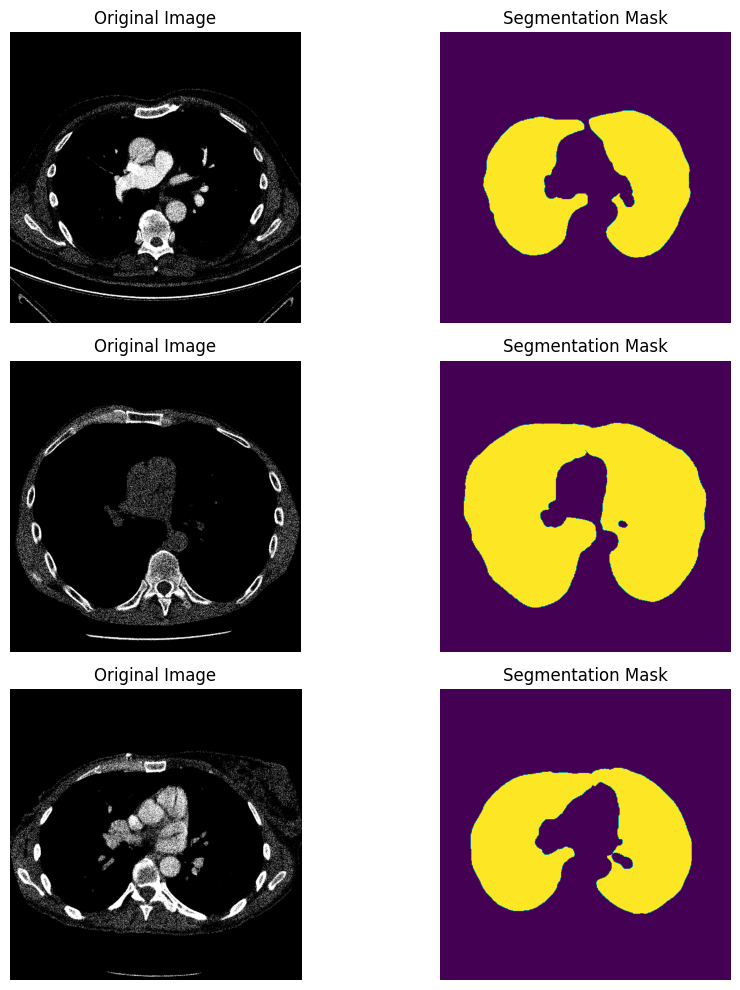

In [ ]:
def visualize_sample_data(image_dir, mask_dir):
    image_filenames = sorted(os.listdir(image_dir))[:3]  # Limit to 3 for visualization
    mask_filenames = sorted(os.listdir(mask_dir))[:3]

    plt.figure(figsize=(10, 10))
    for i in range(len(image_filenames)):
        image_path = os.path.join(image_dir, image_filenames[i])
        mask_path = os.path.join(mask_dir, mask_filenames[i])

        image = Image.open(image_path)
        mask = Image.open(mask_path)

        plt.subplot(3, 2, 2 * i + 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')
        plt.subplot(3, 2, 2 * i + 2)
        plt.imshow(mask)
        plt.title("Segmentation Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_sample_data(image_dir, mask_dir)


 # Data Preprocessing

In [ ]:
# Read and preprocess the images and masks

def load_images(image_folder, mask_folder, image_size):
    images = []
    masks = []
    for img_file in os.listdir(image_folder):
        img = Image.open(os.path.join(image_folder, img_file)).convert('RGB').resize(image_size)
        images.append(np.array(img))
        mask = Image.open(os.path.join(mask_folder, img_file.replace('.tif', '.tif'))).resize(image_size)
        masks.append(np.array(mask))
    return np.array(images), np.array(masks)

# Load the images and masks
image_size = (128, 128)  # You can change this
images, masks = load_images('/content/drive/MyDrive/j_dataset/2d_images', '/content/drive/MyDrive/j_dataset/2d_masks', image_size)

# Normalize images
images = images / 255.0
masks = np.where(masks > 0, 1, 0)
masks = to_categorical(masks, num_classes=2)  # Assuming binary segmentation

# Build the U-Net Model

In [ ]:
from tensorflow.keras import layers, models

def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = layers.concatenate([up4, conv2])
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.concatenate([up5, conv1])
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(2, 1, activation='sigmoid')(conv5)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 64, 64, 256)    │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 384)    │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 128)    │        442,496 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 128, 128, 128)  │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 128, 128, 192)  │              0 │ up_sampling2d_1[0][0], │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 64)   │        110,656 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)    

 Total params: 1,883,202 (7.18 MB)

 Trainable params: 1,883,202 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

### Save the Trained Model

In [ ]:

# Split the data
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16)

# Save the model
model.save('unet_segmentation.h5')


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6749 - loss: 0.6439 - val_accuracy: 0.7506 - val_loss: 0.4891
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 132ms/step - accuracy: 0.8004 - loss: 0.4194 - val_accuracy: 0.8917 - val_loss: 0.2633
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9036 - loss: 0.2479 - val_accuracy: 0.9577 - val_loss: 0.1121
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9507 - loss: 0.1344 - val_accuracy: 0.9368 - val_loss: 0.1624
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9509 - loss: 0.1502 - val_accuracy: 0.9702 - val_loss: 0.0768
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9678 - loss: 0.0927 - val_accuracy: 0.9549 - val_loss: 0.1041
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9640 - loss: 0.1009 - val_accuracy: 0.9731 - val_loss: 0.0816
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9697 - loss: 0.0962 - val_accuracy: 0.9

In [ ]:
# Evaluate on validation set
loss, acc = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {acc * 100:.2f}%')


2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 7s/step - accuracy: 0.9830 - loss: 0.0433
Validation Accuracy: 98.32%


# Plot Training Results

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


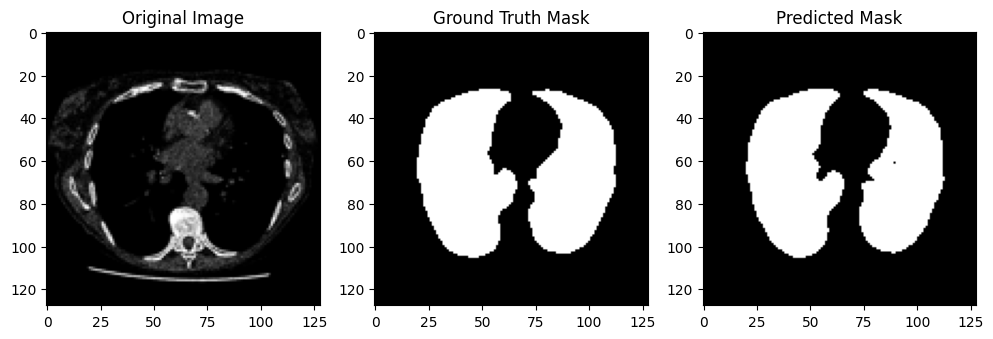

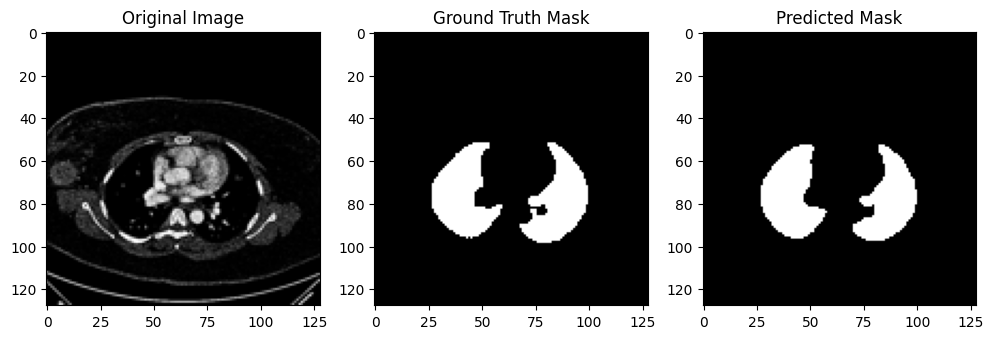

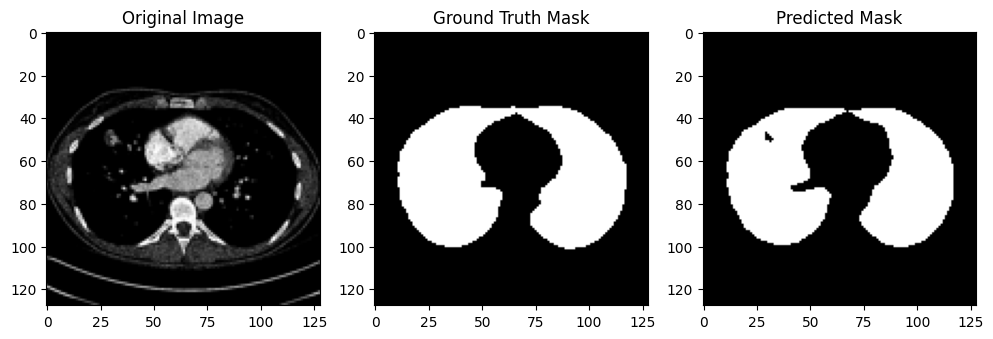

In [ ]:
# Predict on validation data
predictions = model.predict(X_val)

# Display results
n = 3  # Number of samples to display
for i in range(n):
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[i])
    plt.title('Original Image')

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(np.argmax(y_val[i], axis=-1), cmap='gray')
    plt.title('Ground Truth Mask')

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(np.argmax(predictions[i], axis=-1), cmap='gray')
    plt.title('Predicted Mask')

    plt.show()


 # Evaluate the Model

In [ ]:
def iou_metric(y_true, y_pred):
    y_pred = np.round(y_pred)  # Round predictions to 0 or 1
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union

iou_scores = [iou_metric(y_val[i], predictions[i]) for i in range(len(y_val))]
print(f'Average IoU: {np.mean(iou_scores):.4f}')


Average IoU: 0.9670


### The IoU score on the validation set (IoU = 0.9726)

In [ ]:
import numpy as np

def dice_coefficient(y_true, y_pred):
    y_pred = np.round(y_pred)  # Round predictions to 0 or 1
    intersection = np.sum(y_true * y_pred)
    return 2 * intersection / (np.sum(y_true) + np.sum(y_pred))

dice_scores = [dice_coefficient(y_val[i], predictions[i]) for i in range(len(y_val))]
print(f'Average Dice Coefficient: {np.mean(dice_scores):.4f}')


Average Dice Coefficient: 0.9832
